# What's happening in SA

In [2]:
#data wrangle
import pandas as pd
import numpy as np
import re

#aquire data
import requests
from bs4 import BeautifulSoup

#plot
import matplotlib.pyplot as plt 
import seaborn as sns

## Acquire

Obatined COVID data for Bexar county here: https://www.sanantonio.gov/Health/News/Alerts/CoronaVirus#281783804-public-info- 

I'm glad they're posting the COVID data for people's consumption. However, it's not available in a csv or json or api for the data scientist. #thanksbutnothanks 

Time to webscrape.

In [326]:
# ping SA cite and gather all the tables
response = requests.get("https://www.sanantonio.gov/Health/News/Alerts/CoronaVirus#281783804-public-info-")
soup = BeautifulSoup(response.text, 'html.parser')
table = soup.find_all("table",{"class":"covidData"})

In [334]:
len(table)

15

In [423]:
def make_df(table_no):    
    '''
    From all the tables pulled, make one dataframe based on teh table number entered
    '''
    data = []

    #get table data
    table_title = table[table_no].find('thead')
    table_body = table[table_no].find('tbody')
 
    #create header
    rows = table_title.find_all('tr')
    for row in rows:
        titles = row.find_all('th')
        header = []
        for title in titles[:2]:
            title = title.text
            title = re.sub('\n\s+',' ',title)
            title = title.lower()
            header.append(title)

    #create body
    rows = table_body.find_all('tr')
    for row in rows:
        name = row.find('th').text
        name = re.sub('\n\s+', '', name)
        name = name.strip()

        col = row.find('td').text
        col = col.replace(",","")
        col = int(col)
        data.append([name, col])

    return pd.DataFrame(data, columns=header) #return df

## Prepare & Explore

### Total Cases

In [336]:
df = make_df(1)
df

,case status and source of exposure,number
0,Total Confirmed cases Bexar County*,503
1,Travel-related,124
2,Close contact,179
3,Community transmission,150
4,Under investigation,50


In [337]:
df = df.rename(columns={"case status and source of exposure":"source"})

In [338]:
subset = df.loc[1:,]
subset

,source,number
1,Travel-related,124
2,Close contact,179
3,Community transmission,150
4,Under investigation,50


In [339]:
print(f"In Bexar county, there have been {df.iloc[0,1]} confirmed cases.")

In Bexar county, there have been 503 confirmed cases.


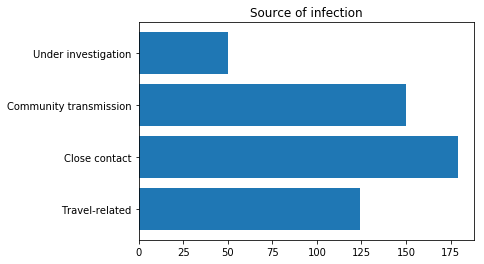

In [340]:
plt.barh(subset.source,subset.number)
plt.title("Source of infection")
plt.show()

### Total Tests

In [424]:
df = make_df(13)
df

,test results,number
0,Negative,4075
1,Positive,527
2,Inconclusive,10
3,Total tested,4612


In [425]:
df = df.rename(columns={"test results":"testing"})

In [426]:
subset = df.loc[0:2,]
subset

,testing,number
0,Negative,4075
1,Positive,527
2,Inconclusive,10


In [427]:
print(f'There have been {df.iloc[3,1]} total tests taken in Bexar county.')

There have been 4612 total tests taken in Bexar county.


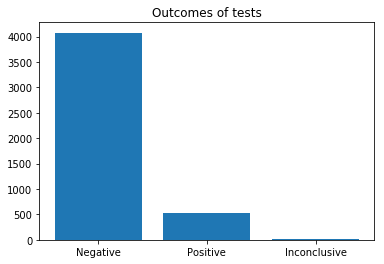

In [428]:
plt.bar(subset.testing,subset.number)
plt.title("Outcomes of tests")
plt.show()

### Status

In [429]:
df = make_df(5)
df

,case status,number
0,Recovered,77
1,Still Ill,408
2,Deceased,18


In [430]:
df = df.rename(columns={"case status":"status"})

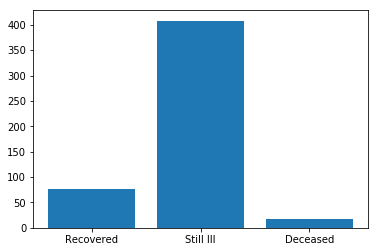

In [432]:
plt.bar(df.status, df.number)
plt.show()

### Hopitalizations

In [440]:
data = []

table_title = table[9].find('thead')
table_body = table[9].find('tbody')

# create header
rows = table_title.find_all('tr')
for row in rows:
    titles = row.find_all('th')
    header = []
    for title in titles[:2]:
        if len(title) > 0:
            title = title.text
            title = re.sub('\n\s+',' ',title)
            title = title.lower()
        else:
            title = "none"
        header.append(title)

#create body
rows = table_body.find_all('tr')
for row in rows:
    subrows = row.find_all('td')
    for subrow in subrows[:2]:
        subrow = subrow.text
        subrow = re.sub('\s+',' ',subrow) 
        data.append(subrow)

#split array in half
data = np.array_split(data,2)

df = pd.DataFrame(data, columns = header)
df

,none,number
0,Not Hospitalized,344
1,Ever Hospitalized,107


In [441]:
df = df.rename(columns={"none":"status"})
df.number = df.number.astype("int")

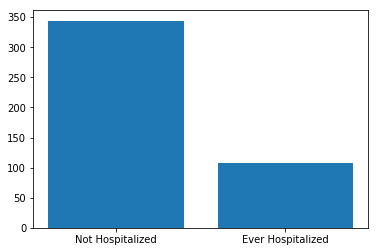

In [442]:
plt.bar(df.status,df.number)
plt.show()

In [288]:
print(f'The percent of people needing hospitalization is {round(df.iloc[1,1]/df.iloc[0,1]* 100,0)}%')

The percent of people needing hospitalization is 33.0%


### Hospital Characteristics

In [443]:
data = []

table_title = table[10].find('thead')
table_body = table[10].find('tbody')

#create body
rows = table_body.find_all('tr')
for row in rows[:2]:
    subrows = row.find_all('td')
    for subrow in subrows[:2]:
        subrow = subrow.text
        subrow = re.sub('\s+',' ',subrow) 
        data.append(subrow)

data = " ".join(data).split()
data.remove('Ever')
data.remove('Mechanical')
data.pop(4)
data = data[:-2]

df = pd.DataFrame(np.array_split(data,3), columns=["type","number"])
df

,type,number
0,Hospitalized,107
1,ICU,54
2,Ventilator,29


In [451]:
df.number = df.number.astype(int)

In [452]:
df["percent"] = round(df.number / df.iloc[0,1], 2)

In [453]:
df

,type,number,percent
0,Hospitalized,107,1.00
1,ICU,54,0.50
2,Ventilator,29,0.27


In [454]:
nada = int((1 - (df.iloc[2,2] + df.iloc[1,2])) * 100)

In [455]:
print(f'The percent of people not requiring the ICU or a ventilator is {nada}% ')

The percent of people not requiring the ICU or a ventilator is 23% 


### Hospitial Visit

In [371]:
df = make_df(6)
df

,medical visit type,number
0,Drive Through,51
1,Clinic/Provider,167
2,Urgent Care/Emergency Department/Hospital,275


In [372]:
df = df.rename(columns={"medical visit type":"type"})

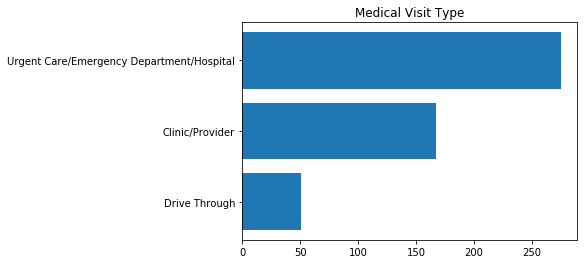

In [373]:
plt.barh(df.type, df.number)
plt.title('Medical Visit Type')
plt.show()

### Cases and Deaths by Gender

In [381]:
df_cases = make_df(2)
df_cases

,gender,number
0,Male,237
1,Female,266


In [382]:
df_deaths = make_df(7)
df_deaths

,gender,number
0,Male,9
1,Female,9


In [387]:
df_cases = df_cases.rename(columns={"number":"cases"})
df_deaths = df_deaths.rename(columns={"number":"deaths"})

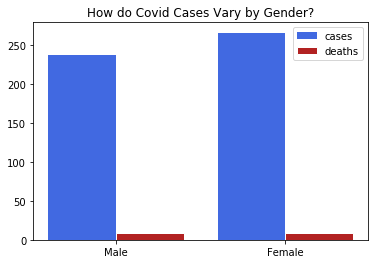

In [391]:
barWidth = 0.4
 
# set position of bar on x axis
r1 = np.arange(len(df_cases))
r2 = [x + barWidth for x in r1]
 
# plot
plt.bar(r1, df_cases.cases, color='royalblue', width=barWidth, label='cases')
plt.bar(r2, df_deaths.deaths, color='firebrick', width=barWidth, edgecolor='white', label='deaths')

plt.title("How do Covid Cases Vary by Gender?")
plt.xticks([r + barWidth/2 for r in range(len(df_cases))], ['Male', 'Female'])
plt.legend(loc=1)
plt.show()

### Cases and Deaths by Age

In [413]:
df_cases = make_df(3)
df_cases

,age group (in years),number
0,0-19,17
1,20-29,70
2,30-39,72
3,40-49,98
4,50-59,88
5,60-69,85
6,70-79,43
7,80-89,24
8,90-99,3
9,100-109,1


In [414]:
df_deaths = make_df(8)
df_deaths

,age group (in years),number
0,0-19,0
1,20-29,0
2,30-39,0
3,40-49,2
4,50-59,3
5,60-69,3
6,70-79,1
7,80-89,8
8,90-99,1
9,100-109,0


In [415]:
df_cases = df_cases.rename(columns={"age group (in years)":"age","number":"cases"})
df_deaths = df_deaths.rename(columns={"age group (in years)":"age","number":"deaths"})

In [419]:
df_age = pd.merge(df_cases, df_deaths)
df_age

,age,cases,deaths
0,0-19,17,0
1,20-29,70,0
2,30-39,72,0
3,40-49,98,2
4,50-59,88,3
5,60-69,85,3
6,70-79,43,1
7,80-89,24,8
8,90-99,3,1
9,100-109,1,0


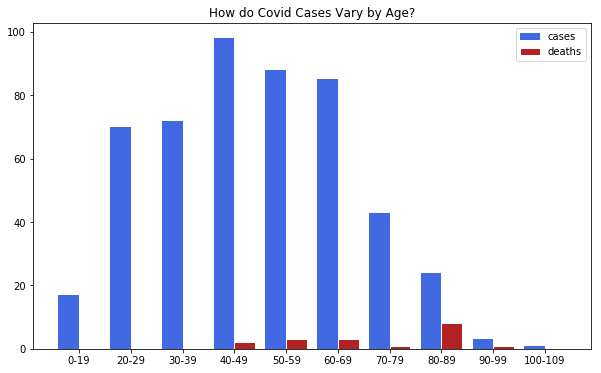

In [420]:
plt.figure(figsize=(10,6))

barWidth = 0.4
 
# set position of bar on x axis
r1 = np.arange(len(df_cases))
r2 = [x + barWidth for x in r1]
 
# plot
plt.bar(r1, df_age.cases, color='royalblue', width=barWidth, label='cases')
plt.bar(r2, df_age.deaths, color='firebrick', width=barWidth, edgecolor='white', label='deaths')

plt.title("How do Covid Cases Vary by Age?")
plt.xticks([r + barWidth/2 for r in range(len(df_cases))], list(df_cases.age))
plt.legend(loc=1)
plt.show()

## Next Steps

- pull stats daily into JSON so a time analysis can be done
- where are the racial breakdowns?
    - they added them! new scrape time!